In [82]:
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchinfo


In [83]:
!pip3 install google-colab

In [84]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import OneSidedSelection, InstanceHardnessThreshold, NearMiss, ClusterCentroids
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns


In [85]:
'''CONFIG FOR LOCAL / CLOUD RUNNING'''
running_local = 'content' not in os.getcwd()
if running_local:
    path = ''
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path = 'drive/MyDrive/StructuralBioinformatics/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# RUN ONLY TO REBUILD DATASET CSV
#dfs = []
#for filename in os.listdir('features_ring'):
#    if filename[-4:] == '.tsv':
#        dfs.append(pd.read_csv('features_ring/' + filename, sep='\t'))
#df = pd.concat(dfs)
#df

In [87]:
# don't need to execute - only to export df for training in cloud
#df.to_csv('contact_df.csv')

In [88]:
df = pd.read_csv(path + 'data/contact_df.csv')
df.dropna(inplace=True)

# Define ground truth values
y = df['Interaction'].astype('category')
y_oneHot = pd.get_dummies(y)
cat_names = list(y.cat.categories)
y


0               VDW
1             HBOND
2             HBOND
3         PIPISTACK
4             HBOND
            ...    
454188          VDW
454189        HBOND
454190          VDW
454191        HBOND
454192        HBOND
Name: Interaction, Length: 454193, dtype: category
Categories (6, object): ['HBOND', 'IONIC', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [89]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5',
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

#is this working?
X = X.fillna({col: X[col].mode()[0] for col in X.columns})

print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Scaling data...


In [90]:
# Create the test and train split (from ORIGINAL data)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_oneHot, test_size=0.1, random_state=123)

# TO FIX: WE NEED A VALIDATION SET THAT IS NOT AFFECTED BY THE PREPROCESSING!
# For now, I'm using the test set with a constraint on the indexes in the training function to use as a validation set, but we need a better solution.

n_splits=10
kf = KFold(n_splits=n_splits, shuffle=True)

In [91]:
# Preprocessing TRAIN DATA ONLY

#X_scaled = pd.DataFrame(X_scaled, columns=X.columns) #why are we casting it to a DF?
X_train = np.array(X_train) #undersampler and oversampler expects arrays
y_train = np.array(y_train) #undersampler and oversampler expects arrays


print("Undersampling data...")
undersample = InstanceHardnessThreshold(estimator=AdaBoostClassifier(),sampling_strategy={0:50000,5:50000})
X_train, y_train = undersample.fit_resample(X_train, y_train)

print("Oversampling data...")
oversample = SMOTE(sampling_strategy={1:50000,3:50000,2:50000,4:50000})
X_train, y_train = oversample.fit_resample(X_train, y_train)

Undersampling data...
Oversampling data...


In [92]:
# Recast into Dataframes (to fix: conventionally np.arrays are to be fed to the network, not DataFrames)

X_train = pd.DataFrame(X_train, columns=X.columns)
y_train = pd.DataFrame(y_train)

X_test = pd.DataFrame(X_test, columns=X.columns)
y_test = pd.DataFrame(y_test)

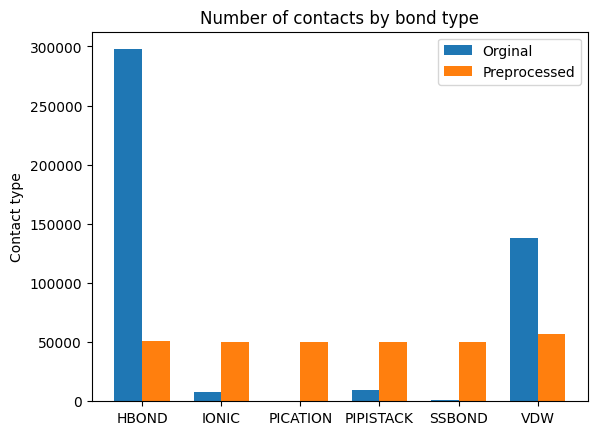

In [93]:
y_arg = np.argmax(y_oneHot.values, axis=1)
y_arg_processed = np.argmax(y_train.values, axis=1)
_, count = np.unique(y_arg, return_counts=True)
class_count = dict(zip(cat_names, count))
_, count_processed = np.unique(y_arg_processed, return_counts=True)
class_count_processed = dict(zip(cat_names, count_processed))

fig, ax = plt.subplots()
x = np.arange(len(cat_names))  # label locations
width = 0.35  # width of the bars
rects1 = ax.bar(x - width/2, count, width, label='Orginal')
rects2 = ax.bar(x + width/2, count_processed, width, label='Preprocessed')

# Add labels, title, and legend
ax.set_ylabel('Examples')
ax.set_ylabel('Contact type')
ax.set_title('Number of contacts by bond type')
ax.set_xticks(x)
ax.set_xticklabels(cat_names)
ax.legend()

plt.show()

In [127]:
class ContactNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_layers_dim=[]):
        super().__init__()
        self.layers = nn.ModuleList()
        if len(hidden_layers_dim) == 0:
            self.layers = self.layers.append(nn.Linear(input_dim, num_classes))
        else:
            for layer_idx in range(len(hidden_layers_dim)):
                if layer_idx == 0:  # first layer, from input to hidden
                    self.layers = self.layers.append(nn.Linear(input_dim, hidden_layers_dim[layer_idx]))
                else:  # hidden layers, depending on the input
                    self.layers = self.layers.append(nn.Linear(hidden_layers_dim[layer_idx-1], hidden_layers_dim[layer_idx]))
            self.layers = self.layers.append(nn.Linear(hidden_layers_dim[-1], num_classes))  # final output layer
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=.1)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        if x.dtype != torch.float32:
            x = x.float()
        if len(self.layers) == 1:
            return self.layers[0](x)
        else:
            for layer in self.layers[:-1]:
                x = F.relu(layer(x))
        return F.log_softmax(x, dim=1)#self.layers[-1](x)

input_size = X.shape[1]  # The number of input features
num_classes = y_oneHot.shape[1] # The number of output classes

model = ContactNet(input_size, num_classes, [60, 60, 128, 128, 128, 128, 256, 256, 256, 256])

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()

lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

summary(model)

Layer (type:depth-idx)                   Param #
ContactNet                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       1,260
│    └─Linear: 2-2                       3,660
│    └─Linear: 2-3                       7,808
│    └─Linear: 2-4                       16,512
│    └─Linear: 2-5                       16,512
│    └─Linear: 2-6                       16,512
│    └─Linear: 2-7                       33,024
│    └─Linear: 2-8                       65,792
│    └─Linear: 2-9                       65,792
│    └─Linear: 2-10                      65,792
│    └─Linear: 2-11                      1,542
Total params: 294,206
Trainable params: 294,206
Non-trainable params: 0

In [130]:
class EarlyStopping:
    def __init__(self, tolerance):
        self.tolerance = tolerance
        self.counter = 0
        self.best_val_loss= 0
        self.early_stop = False

    def __call__(self, val_loss):
          if val_loss < self.best_val_loss:
              self.best_val_loss = val_loss
              self.counter = 0
          else:
              self.counter += 1
              if self.counter >= self.tolerance:
                  self.early_stop=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TO DO: Cast all dataframes to np.arrays or torch.tensors

def train(model, optimizer, num_epochs, l1_lambda):
    early_stopping = EarlyStopping(tolerance=20) # slow to learn, so it has to be VERY tolerant

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    current_fold_counter=0

    for train_index, val_index in kf.split(X_train): # temporarily discarding kfold to test on test set and have a baseline. Remember to reindent all under this

      current_fold_counter += 1

      early_stopping.early_stop = False
      early_stopping.counter = 0

      X_train_fold = X_train.values[train_index] #Recasted to a pd.DataFrame but ideally we should use np.ndarray everywhere
      y_train_fold = y_train.values[train_index]


      # Here I'm just trying to see if maybe I can reuse the entire test set with validation indexes from X_train without going out of bound.
      # I don't even know if this makes sense but that's the only thing that I could think as of right now
      val_index_adjusted = val_index[val_index < len(X_test)]
      X_val_fold = X_test.values[val_index_adjusted]
      y_val_fold = y_test.values[val_index_adjusted]

      #X_val_fold = X_train.values[val_index]
      #y_val_fold = y_train.values[val_index]


      for epoch in range(num_epochs):
          model.train()
          out = model(torch.tensor(X_train_fold))
          y_train_fold_labels = np.argmax(y_train_fold, axis=1)
          loss = criterion(out, torch.tensor(y_train_fold_labels).long())

          ############## L1 Regularization ################
          parameters = torch.tensor([], device=device)
          parameters = torch.cat([param.view(-1) for param in model.parameters()], dim=0)

          l1_norm = torch.linalg.norm(parameters, 1)
          loss = loss + l1_norm * l1_lambda

          #################################################

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():
            val_outputs = model(X_val_fold)
            y_val_fold_labels = np.argmax(y_val_fold, axis=1)
            val_loss = criterion(val_outputs, torch.tensor(y_val_fold_labels).long())
            _, val_preds = torch.max(val_outputs, 1)
            val_accuracy = (val_preds == torch.tensor(y_val_fold_labels)).sum().item() / len(y_val_fold_labels)
            train_preds = torch.argmax(out, 1)
            train_accuracy = (train_preds == torch.tensor(y_train_fold_labels)).sum().item() / len(y_train_fold_labels)


          print(f'Fold: {current_fold_counter}/{n_splits} - Epoch {epoch+1}/{num_epochs}')
          print(f'Train Loss: {loss.item()} - Validation Loss: {val_loss.item()} - Train Accuracy: {train_accuracy} - Validation Accuracy: {val_accuracy}')

          train_losses.append(loss.item())
          val_losses.append(val_loss.item())
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)

          #early_stopping(val_loss.item())
          #if early_stopping.early_stop:
          #    print('Early stopping triggered...')
          #    break

      #if early_stopping.early_stop:
      #    break

    return train_losses, val_losses, train_accuracies, val_accuracies

In [131]:
EPOCHS = 50

train_loss, val_loss, train_accuracy, val_accuracy = train(model, optimizer, num_epochs=EPOCHS, l1_lambda=0.01)

Fold: 1/10 - Epoch 1/50
Train Loss: 235.52879333496094 - Validation Loss: 5.45695161819458 - Train Accuracy: 0.0005439422484627328 - Validation Accuracy: 0.007244736246321032
Fold: 1/10 - Epoch 2/50
Train Loss: 232.63018798828125 - Validation Loss: 5.440510272979736 - Train Accuracy: 0.0020316783320064986 - Validation Accuracy: 0.016753452569617387
Fold: 1/10 - Epoch 3/50
Train Loss: 229.76573181152344 - Validation Loss: 5.424048900604248 - Train Accuracy: 0.005363774887159001 - Validation Accuracy: 0.03780846728548789
Fold: 1/10 - Epoch 4/50
Train Loss: 226.93704223632812 - Validation Loss: 5.407153606414795 - Train Accuracy: 0.012283728922237872 - Validation Accuracy: 0.09667194928684628
Fold: 1/10 - Epoch 5/50
Train Loss: 224.13038635253906 - Validation Loss: 5.390138149261475 - Train Accuracy: 0.03273019383796285 - Validation Accuracy: 0.2223228435589767
Fold: 1/10 - Epoch 6/50
Train Loss: 221.34706115722656 - Validation Loss: 5.373048305511475 - Train Accuracy: 0.07931830707881399

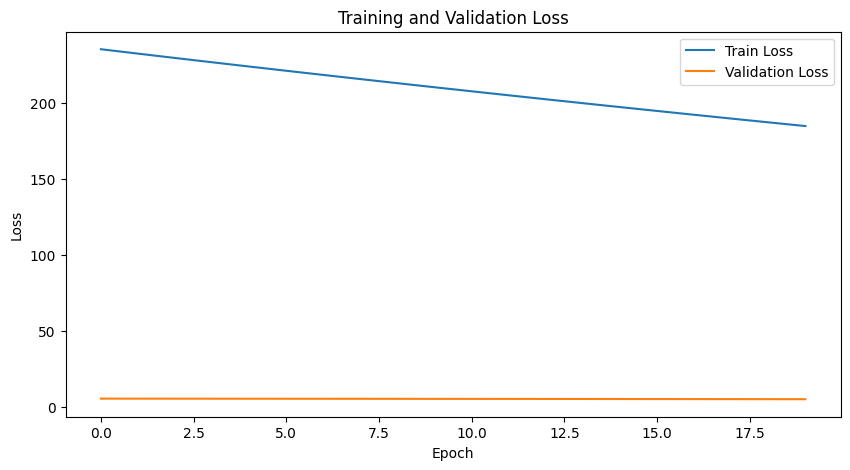

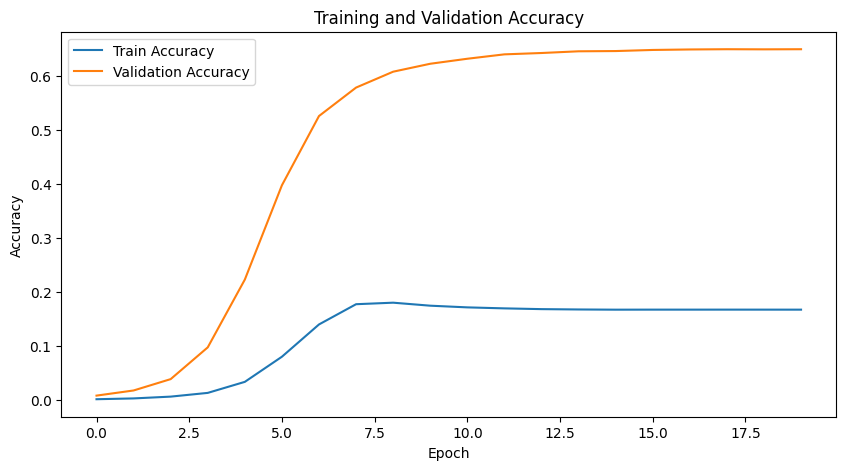

In [132]:


# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:

if running_local:
    PATH = "model/model.pth"
else:
    PATH = "drive/MyDrive/StructuralBioinformatics/model/model.pth"

In [ ]:
torch.save(model, PATH)

In [ ]:
# Load Model For Inference

model = torch.load(PATH)
model.eval()

In [ ]:
# Convert your test dataset into PyTorch tensors
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values).long()

# Create a DataLoader for your test set
test_dataset = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Forward pass
        outputs = model(inputs)

        # Get predicted class indices
        _, preds = torch.max(outputs, 1)

        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

y_pred_oneHot = pd.get_dummies(y_pred).values
print(classification_report(y_true, y_pred_oneHot, target_names = cat_names))

In [ ]:
cm = confusion_matrix(np.argmax(y_true,axis=1), y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cat_names)
cm_display.plot(cmap='Blues', ax=ax)

plt.title('Confusion Matrix')
plt.ylabel('Actual Contact')
plt.xlabel('Predicted Contact')
plt.show()